# Emotion Recognition and Neural Network

In this notebook, I'm going to analyze the dataset of 28709 images, each is 48x48 pixel grayscale, to predict 7 face expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) using convolutional neural network.


* [Imports](#1.Imports)
* [Preprocessing](#2.Preprocessing)
* [Modeling. Convolutional Neaural Network](#3.CNN)
* [Visualization of CNN](#4.Visualization)
* [Data Augmentation and Convnets](#5.Data-Augmentation-and-Convnets)
* [Evaluate predictions](#6.Evaluate-predictions)
* [Predict labels on new images](#7.Predict-labels-on-new-images)
* [Conclusion and model analysis](#8.Conclusion)
* [Dictionary and literacy](#9.Dictionary)
* [References](#10.References:)

## 1.Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, image

from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

import cv2 as cv

In [35]:
df = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [36]:
df.head(3)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...


## 2.Preprocessing

In [4]:
# Emotions distribution
df['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

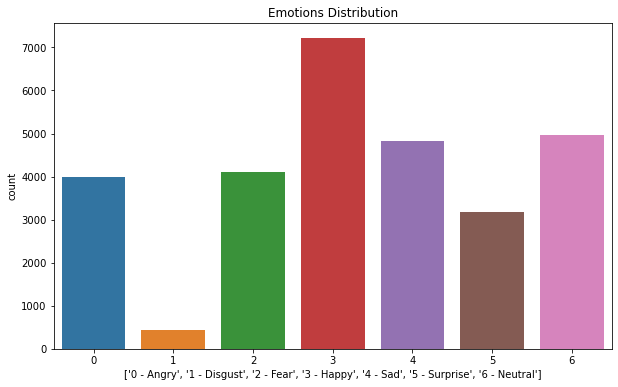

In [63]:
# Visual emotions distributions
plt.figure(figsize = (10,6))

sns.countplot(data = df, x='emotion').set_title('Emotions Distribution')
plt.xlabel(['0 - Angry', '1 - Disgust',  '2 - Fear',  '3 - Happy',  '4 - Sad', '5 - Surprise', '6 - Neutral']);

In [37]:
# function to convert 1d pixels to array
def converter(pixels):
    return np.array(pixels.split(),"float64")

In [38]:
# convert to array
df['pixels_array'] = df["pixels"].apply(converter)
test['pixels'] = test['pixels'].apply(converter)

In [39]:
# Scale
df['pixels_array']/=255.
test['pixels']/=255.

In [40]:
# reshape to 48*48 since the shape of single pic is 2304
image = np.reshape(list(df['pixels_array']),(df.shape[0],48,48,1))
image_test = np.reshape(list(test['pixels']),(test.shape[0],48,48,1))
image.shape

(28709, 48, 48, 1)

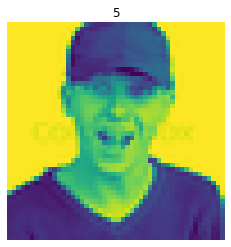

In [69]:
# Check a single image
plt.imshow(image[55])
plt.title(df['emotion'][55])
plt.axis('off');

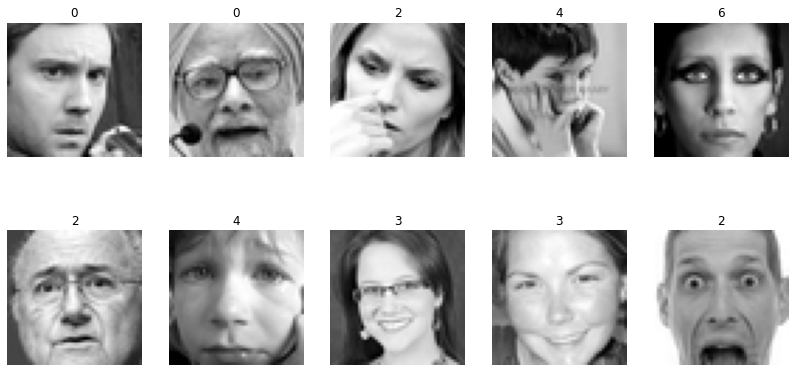

In [70]:
# Look at first 10 images

plt.figure(figsize=[14,7])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image[i],cmap="gray")
    plt.title(df['emotion'][i])
    plt.axis("off")
plt.show()

## 3.CNN

In [41]:
# Identify X, y and train_test_split:

X = image    
y = to_categorical(df['emotion'])

X_train,X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [11]:
# Baseline score

y.mean(axis=0)

array([0.13915497, 0.01518688, 0.14270785, 0.2513149 , 0.16823992,
       0.11045317, 0.17294228], dtype=float32)

In [42]:
# Instantiate the model

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size = (3,3), activation ='relu', input_shape = (48,48,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2)))


cnn.add(Conv2D(64, kernel_size = (3,3), activation ='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2)))


cnn.add(Conv2D(128, kernel_size = (3,3), activation ='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2)))


cnn.add(Flatten()) 

cnn.add(Dense(512, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(256, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(7, activation = 'softmax'))

In [82]:
# Look at the summary of our model
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_24 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 21, 21, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 128)        

In [43]:
# Compile

cnn.compile(loss='categorical_crossentropy', 
#           optimizer = 'adam', 
            optimizer = Adam(learning_rate=0.0001), 
            metrics = ['accuracy'])

In [30]:
# Callbacks

callback_list = [ EarlyStopping( monitor='accuracy', # monitor accuracy
                                 patience=2,    # Training will interrupted when acc stops improving after 1 epoch
                                 restore_best_weights=True),
                  
                  # This callback will save the current weights after every epoch
                  ModelCheckpoint(filepath='./data/save/cnn_weights1', # Path to the destination model file
                                  monitor='val_loss',            # not overwrite the model file unless `val_loss` has improved
                                  save_best_only=True),          # keep the best model every seen during training.
                 
                 # reduce the learning rate when the validation loss has stopped improving
                 # Monitor the validation loss of the model
                  ReduceLROnPlateau(monitor='val_loss',  # Monitor val_loss
                                    factor=0.1,          # It will divide the learning by 10 when it gets triggered
                                    patience=3)]         # It will get triggered after the val_loss has stopped improving
                                                        # for at least 3 epochs


In [15]:
# Fit and train

history = cnn.fit(X_train, y_train,
                  batch_size= 32,
                  validation_data = (X_val, y_val),
                  epochs=23,
                  callbacks = callback_list,
                  verbose=1)

Epoch 1/23
673/673 [==============================] - 68s 91ms/step - loss: 1.8425 - accuracy: 0.2961 - val_loss: 1.5875 - val_accuracy: 0.3863
INFO:tensorflow:Assets written to: ./data/save\cnn_weights1\assets
Epoch 2/23
673/673 [==============================] - 67s 99ms/step - loss: 1.5632 - accuracy: 0.3975 - val_loss: 1.4713 - val_accuracy: 0.4390
INFO:tensorflow:Assets written to: ./data/save\cnn_weights1\assets
Epoch 3/23
673/673 [==============================] - 66s 98ms/step - loss: 1.4429 - accuracy: 0.4394 - val_loss: 1.3998 - val_accuracy: 0.4653
INFO:tensorflow:Assets written to: ./data/save\cnn_weights1\assets
Epoch 4/23
673/673 [==============================] - 63s 94ms/step - loss: 1.3471 - accuracy: 0.4806 - val_loss: 1.3573 - val_accuracy: 0.4817
INFO:tensorflow:Assets written to: ./data/save\cnn_weights1\assets
Epoch 5/23
673/673 [==============================] - 66s 99ms/step - loss: 1.2600 - accuracy: 0.5219 - val_loss: 1.3089 - val_accuracy: 0.4965
INFO:tensorf

## 4.Visualization

In [86]:
# Evaluate  only last epoch
cnn.evaluate(X_val,y_val)

225/225 [==============================] - 13s 17ms/step - loss: 1.4633 - accuracy: 0.5822


[1.4632899761199951, 0.5821955800056458]

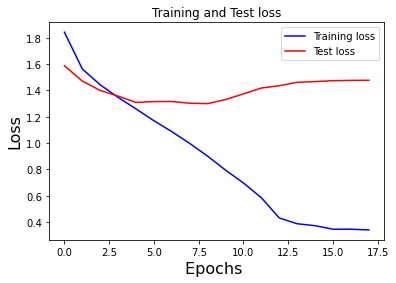

<Figure size 432x288 with 0 Axes>

In [16]:
# Look at the train and test loss

train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show();

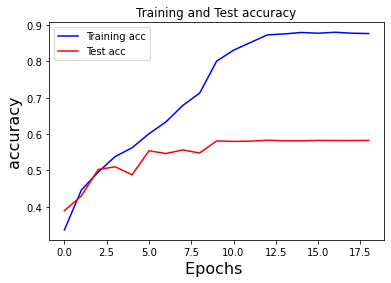

<Figure size 432x288 with 0 Axes>

In [88]:
# Look at the train and test accuracy

train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']


plt.plot(range(len(train_loss)), train_loss, 'b', label='Training acc')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show();

## 5.Data Augmentation and Convnets

  Because the data is generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over.This is the role of the ***steps_per_epoch argument*** . After having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. If batches are 20-sample large, it will take 100 batches until we see 2000 samples. 

 ***Fit_generator validation_data*** is allowed to be a data generator fit itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data
 endlessly, and thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

There are 3 types of how we could load our data to generator: ***flow()***, ***flow_from_directory()***, ***flow_from_dataset()***

In [44]:
# Preparation for the modeling
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

datagen = ImageDataGenerator( rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)

history1 = cnn.fit(x = datagen.flow(X_train, y_train, batch_size=100),
                                   steps_per_epoch= len(X_train)/100,
                                   validation_data=(X_val, y_val),
                                   epochs=19,
                                   verbose=0)

In [45]:
cnn.evaluate(X_val,y_val)

225/225 [==============================] - 12s 18ms/step - loss: 1.3517 - accuracy: 0.4790


[1.3516944646835327, 0.4789634943008423]

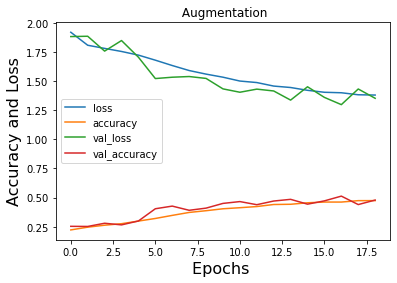

In [47]:
# Let's look at loss and accuracy together

for key in history1.history.keys():
    plt.plot(history1.history[key], label=key)
    
plt.title(' Augmentation')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy and Loss',fontsize=16)
plt.legend();

## 6.Evaluate predictions

In [20]:
# make predictions on a new data

pred_train = cnn.predict(X_val)

In [21]:
# Convert np.arrays to actual images

predicted_images = [np.argmax(i) for i in pred_train]
original_images = [np.argmax(i) for i in y_val]

In [22]:
# Print classification report

print(classification_report(original_images, predicted_images))

              precision    recall  f1-score   support

           0       0.36      0.58      0.44       945
           1       0.26      0.05      0.08        99
           2       0.38      0.25      0.30      1025
           3       0.77      0.77      0.77      1823
           4       0.49      0.33      0.39      1245
           5       0.62      0.69      0.65       819
           6       0.49      0.55      0.52      1222

    accuracy                           0.54      7178
   macro avg       0.48      0.46      0.45      7178
weighted avg       0.54      0.54      0.53      7178



- ***Recall*** from all the positive classes, how many we predicted correctly. Recall should be high as possible.
- ***Precision*** - from all positive classes we have predicted, how many are actually positive.
- ***F-score*** helps to measure Recall and Precision same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.
- ***Support*** is the number of actual occurrences of the class in the specified dataset.

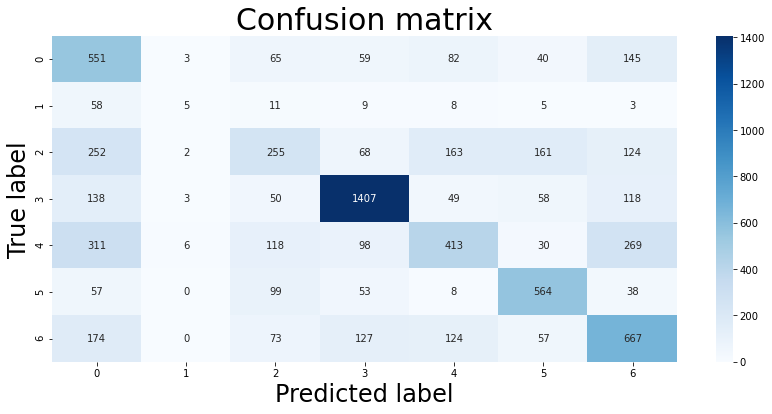

In [23]:
# Print Confusion matrix

plt.figure(figsize=(14,6))
sns.heatmap(confusion_matrix(original_images,predicted_images),annot = True, fmt= "d", cmap = "Blues")
plt.title('Confusion matrix', fontsize = 30)
plt.ylabel('True label', fontsize=24)
plt.xlabel('Predicted label', fontsize = 24);

## 7.Predict labels on new images

In [24]:
# predict 
pred_test = cnn.predict(image_test)

In [25]:
# save predictions and add to df
test['Label_Aug'] = pred_test.argmax(axis = 1)
test.head(4)

,pixels,Label_Aug
0,"[0.996078431372549, 0.996078431372549, 0.99607...",0
1,"[0.611764705882353, 0.7215686274509804, 0.7764...",3
2,"[0.27058823529411763, 0.4627450980392157, 0.23...",0
3,"[0.803921568627451, 0.796078431372549, 0.92549...",2


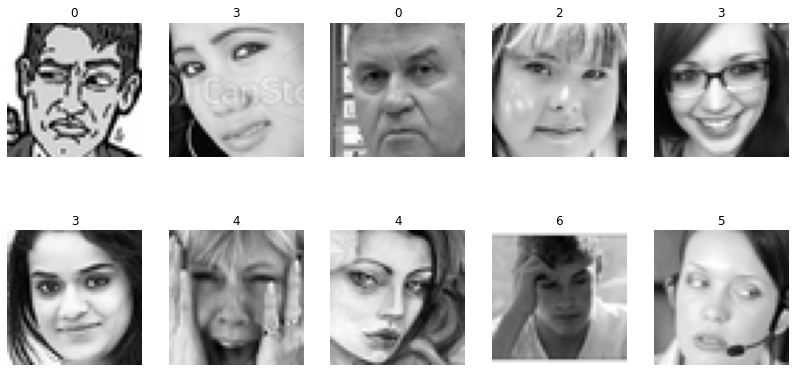

In [26]:
# Look at the first 10 images
# reshape prediction images to 48 by 48 since our len of single image test.pixels[0] is 2304

final_image = np.reshape(test['pixels'].to_list(),(test.shape[0],48,48,1))

#final_image = final_image[60:100]

plt.figure(figsize=[14,7])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(final_image[i],cmap="gray")
    plt.title(test['Label_Aug'][i])
    plt.axis("off")
plt.show()

In [ ]:
['0 - Angry', '1 - Disgust',  '2 - Fear',  '3 - Happy',  '4 - Sad', '5 - Surprise', '6 - Neutral']

## 8.Conclusions and observations:

 - Model overfits without any regularization starting from epoch 3
   
 - Scores achieved after experimenting with different placement of normalization functions:
 
 
 - [1.349, 0.539] dropout/BN
 - [1.815, 0.551] BN/drop
 - [2.100, 0.543] only BN
 - [1.463, 0.582] BN for convolutional layers and Dropouts for Dense layers
 
 
 - Model didn't overfit a lot if I used next order: (Convolutional layer - BN - Activation layer-  Dropout - MaxPooling)
 
 
 - Model achieved a score of 0.58 already at the epoch 9 and didn't improve after this starting  to overfit. 
 
 
 - Data Augmentation is a very useful tool to help with overfitting. It seems the model will never overfit.
 
 
 - My Augmented models were trained at 70 epochs and showed always slow progress every time. I think, if it is trained at more than 500 or 1000 epochs, it could really give accuracy and low loss. Augmented models are trained much slower than not augmented
 
 
 - Model was able to give pretty high scores for emotions if I had more examples of them. For example, the highest score is for 'happiness', but I also have a lot of examples of them to teach my model.

## 9.Dictionary

***Dropouts:*** are the regularization technique that is used to prevent overfitting in the model. Dropouts are added to randomly switching some percentage of neurons of the network. When the neurons are switched off the incoming and outgoing connection to those neurons is also switched off. This is done to enhance the learning of the model. Dropouts are usually advised not to use after the convolution layers, they are mostly used after the dense layers of the network. It is always good to only switch off the neurons to 50%. If we switched off more than 50% then there can be chances when the model leaning would be poor and the predictions will not be good

***Batch Normalization:*** The whole purpose of the BN layer is to output zero mean. Firstly, it reduces internal covariant shift. Secondly, BN reduces the dependence of gradients on the scale of the parameters or of their initial values, which gives a beneficial effect on the gradient flow through the network. This enables the use of higher learning rate without the risk of divergence.Furthermore, BN regularizes the model, and thus reduces the need for Dropout. Finally, BN makes it possible to use saturating nonlinear activation functions without getting stuck in the saturated model.

- increase the learning
- decrease importance of initial weights
- regularize the model

***Callbacks:***
- keras.callbacks.ModelCheckpoint (saving the current weights of the model at different points during training.)
- keras.callbacks.EarlyStopping (interrupting training when the validation loss has stopped improving.)
- keras.callbacks.LearningRateScheduler (adjusting the value of certain param during training, such as the learning rate of the optimizer.)
- keras.callbacks.CSVLogger (Logging the training and validation metrics during training, or visualizing the representations learned by the model)

***Confusion Matrix:*** helps to visualize predictions. Explanation:
* ***TP*** for example, 0-0
* ***TN*** all reversed numbers. 1-6
* ***FP*** 1-6 horizontally
* ***FN*** 1-6 vertically



## 10.References:

* [Summary of neural network](https://arxiv.org/pdf/1512.07108.pdf%C3%A3%E2%82%AC%E2%80%9A)
* [Visual Explanation from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
* [Adam Optimization](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
* [Impact of Learning Rates](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)
* [Augmentation and Fine Tuning](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
[Keras ImageDataGenerator](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)